## Exercise 01: Predict breast cancer

Load the **breast_cancer** dataset in `sklearn.datasets.load_breast_cancer` and play with different classification models to get the best possible cancer estimator

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score

In [3]:
data = load_breast_cancer()

In [4]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'], name='is_benign')
data = pd.concat([X, y], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

## Some EDA

### Check the *a-priori* probability of cancer

In [6]:
data['is_benign'].value_counts()

1    357
0    212
Name: is_benign, dtype: int64

In [7]:
px.pie(data, names="is_benign", template="none", title="A-priori probability of having malignant/benign cancer")

### Calculate correlations between variables (and target)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

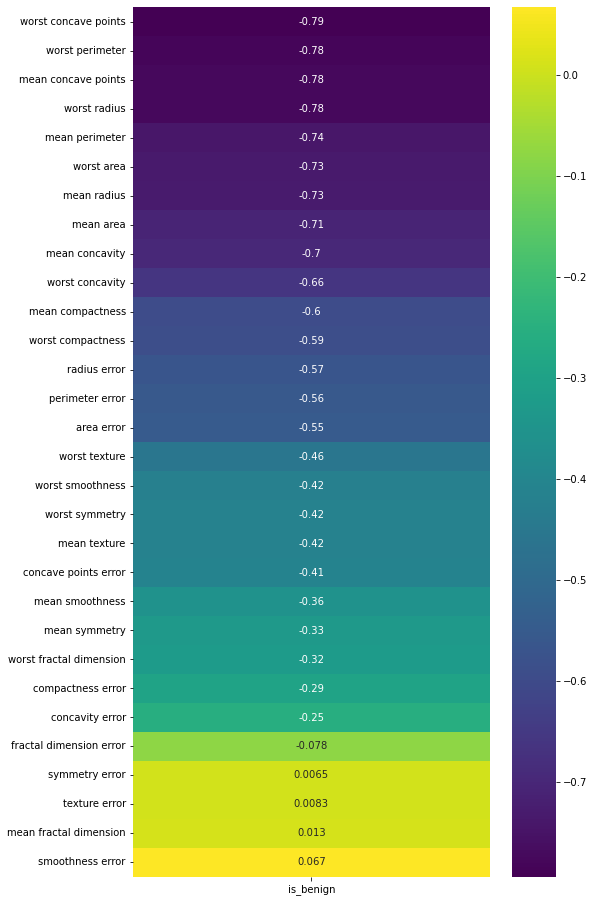

In [9]:
plt.figure(figsize=(8,16))
sns.heatmap(data.corr()['is_benign'][:-1].sort_values().to_frame(), cmap='viridis', annot=True)

We have extracted very interesting information from this analysis:
 - The target is highly correlated with several variables like *radius*, *perimeter* *area*, *concavity*, ...
 - Several of these *important* variables seem to be correlated as well between themselves

### Plot the univariate distribution of features 

In [10]:
def plot_univariate_hist(feature_name):
    return px.histogram(
        data,
        x=feature_name,
        nbins=100,
        color="is_benign",
        marginal="box",
        template="none",
        title=f"Histogram: {feature_name}",
        histnorm="probability density"
    )

In [11]:
plot_univariate_hist("worst concave points")

## Pre-processing

### Train/Test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [13]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
559,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,0.06570,...,12.48,37.16,82.28,474.2,0.12980,0.2517,0.36300,0.09653,0.2112,0.08732
295,13.77,13.27,88.06,582.7,0.09198,0.06221,0.01063,0.01917,0.1592,0.05912,...,14.67,16.93,94.17,661.1,0.11700,0.1072,0.03732,0.05802,0.2823,0.06794
264,17.19,22.07,111.60,928.3,0.09726,0.08995,0.09061,0.06527,0.1867,0.05580,...,21.58,29.33,140.50,1436.0,0.15580,0.2567,0.38890,0.19840,0.3216,0.07570
125,13.85,17.21,88.44,588.7,0.08785,0.06136,0.01420,0.01141,0.1614,0.05890,...,15.49,23.58,100.30,725.9,0.11570,0.1350,0.08115,0.05104,0.2364,0.07182
280,19.16,26.60,126.20,1138.0,0.10200,0.14530,0.19210,0.09664,0.1902,0.06220,...,23.72,35.90,159.80,1724.0,0.17820,0.3841,0.57540,0.18720,0.3258,0.09720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,11.60,12.84,74.34,412.6,0.08983,0.07525,0.04196,0.03350,0.1620,0.06582,...,13.06,17.16,82.96,512.5,0.14310,0.1851,0.19220,0.08449,0.2772,0.08756
322,12.86,13.32,82.82,504.8,0.11340,0.08834,0.03800,0.03400,0.1543,0.06476,...,14.04,21.08,92.80,599.5,0.15470,0.2231,0.17910,0.11550,0.2382,0.08553
382,12.05,22.72,78.75,447.8,0.06935,0.10730,0.07943,0.02978,0.1203,0.06659,...,12.57,28.71,87.36,488.4,0.08799,0.3214,0.29120,0.10920,0.2191,0.09349
365,20.44,21.78,133.80,1293.0,0.09150,0.11310,0.09799,0.07785,0.1618,0.05557,...,24.31,26.37,161.20,1780.0,0.13270,0.2376,0.27020,0.17650,0.2609,0.06735


### Build *Standard Scaler*

In [14]:
sc = StandardScaler()

In [15]:
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_train.columns)

### Feature selection

I'm goint to make a selection just taking into account correlations: keeping the highest correlations in absolute value AND removing colinearities.

Then I'm going to take the subsets of those features in both train and test.

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

X_train_pca.shape

(398, 3)

In [18]:
from mpl_toolkits.mplot3d import Axes3D

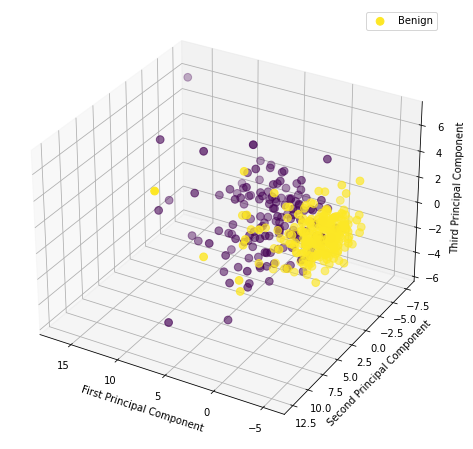

In [19]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], c=y_train, s=60)
ax.legend(['Benign'])
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.view_init(30, 120)

/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Secon Principal Component')

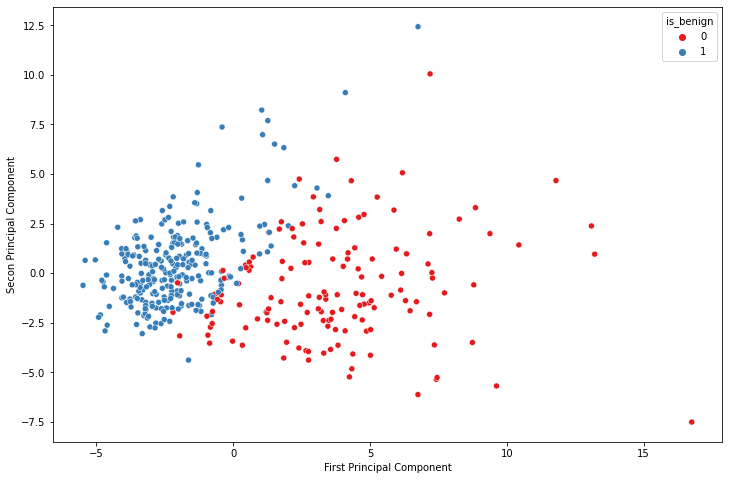

In [20]:
ax = plt.figure(figsize=(12,8))
sns.scatterplot(X_train_pca[:,0], X_train_pca[:,1],hue=y_train, palette ='Set1' )
plt.xlabel('First Principal Component')
plt.ylabel('Secon Principal Component')

/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Third Principal Component')

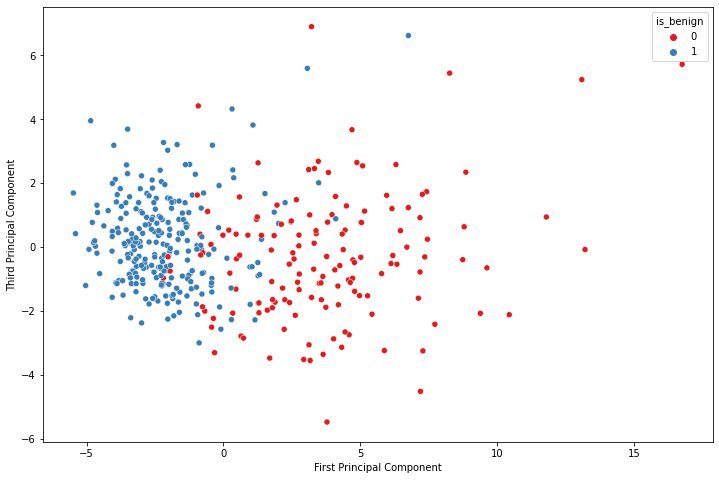

In [21]:
ax = plt.figure(figsize=(12,8))
sns.scatterplot(X_train_pca[:,0], X_train_pca[:,2],hue=y_train, palette ='Set1' )
plt.xlabel('First Principal Component')
plt.ylabel('Third Principal Component')

/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Third Principal Component')

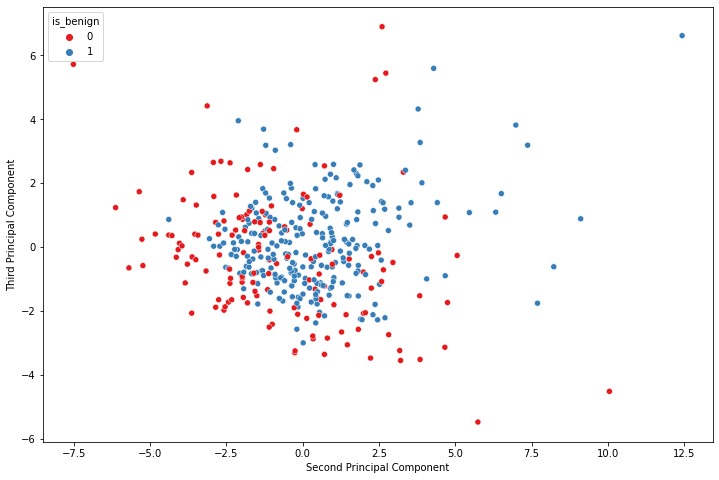

In [22]:
ax = plt.figure(figsize=(12,8))
sns.scatterplot(X_train_pca[:,1], X_train_pca[:,2],hue=y_train, palette ='Set1' )
plt.xlabel('Second Principal Component')
plt.ylabel('Third Principal Component')

In [23]:
data_pca = pd.DataFrame(pca.components_, columns = X_train.columns)
data_pca

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.215096,0.097434,0.224581,0.219141,0.140600,0.237654,0.257734,0.261245,0.141287,0.065926,...,0.225548,0.100347,0.235088,0.223632,0.124402,0.211032,0.226166,0.250759,0.124583,0.128883
1,-0.237394,-0.085055,-0.218320,-0.232373,0.182318,0.154247,0.074643,-0.029526,0.181973,0.364396,...,-0.226904,-0.080950,-0.205926,-0.223380,0.153968,0.126592,0.089619,-0.016948,0.122021,0.267429
2,-0.001643,0.127726,-0.002736,0.027461,-0.155634,-0.079548,0.006280,-0.028146,-0.070276,-0.049642,...,-0.034985,0.020188,-0.038353,-0.001685,-0.304829,-0.240945,-0.159096,-0.171606,-0.290528,-0.235986


Text(114.0, 0.5, 'Principal Components')

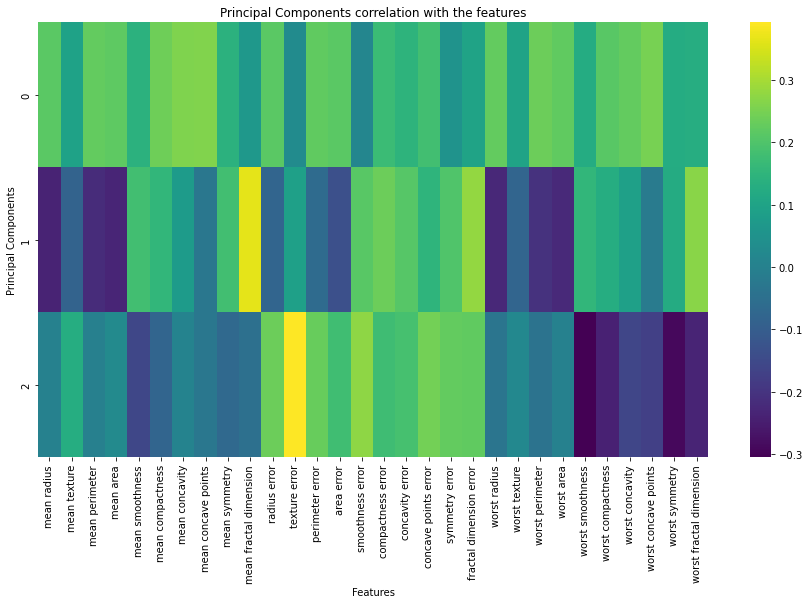

In [24]:
plt.figure(figsize=(15, 8))
sns.heatmap(data_pca, cmap='viridis')
plt.title('Principal Components correlation with the features')
plt.xlabel('Features')
plt.ylabel('Principal Components')

## Algorithms

### **Logistic Regression**

In [25]:
from sklearn.linear_model import LogisticRegression

#### Model definition

In [26]:
clf = LogisticRegression(solver="saga", max_iter=1000)

In [27]:
parameters = {
    "penalty": ["l2", "l1", "elasticnet"],
    "C": np.logspace(-4,4,1000),
    "l1_ratio": np.linspace(0,1,1000)
}

tuner = RandomizedSearchCV(
    clf,
    param_distributions=parameters,
    scoring="roc_auc",                        # recommended for model selection
    cv=5,
    n_iter=100,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

In [28]:
%%time

tuner.fit(X_train_pca, y_train)

/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/youssefawad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty i

CPU times: user 722 ms, sys: 223 ms, total: 945 ms
Wall time: 15.2 s


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, solver='saga'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 1.01861017e-04, 1.03756668e-04, 1.05687597e-04,
       1.07654461e-04, 1.09657929e-04, 1.11698682e-04, 1.13777413e-04,
       1.15894830e-04, 1.18051653e-04, 1.20248614e-04, 1.22486461e-04,
       1.24765955e-04, 1.27087871e-04, 1.294...
       0.97097097, 0.97197197, 0.97297297, 0.97397397, 0.97497497,
       0.97597598, 0.97697698, 0.97797798, 0.97897898, 0.97997998,
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                        'penalty': ['l2', 'l1', 'elasticnet']},
                   return_train_score=True, scoring='roc_auc')

Let's get the results and order them by "mean_test_score"

In [29]:
results = pd.DataFrame(tuner.cv_results_)
results = results.sort_values("mean_test_score", ascending=False)

In [30]:
results.T

,34,33,55,11,64,96,90,0,83,12,...,46,68,1,26,56,8,59,97,3,73
mean_fit_time,0.012218,0.012256,0.00955,0.010279,0.070344,0.012747,0.025368,0.029287,0.063811,0.01918,...,0.007154,0.007543,0.006846,0.005189,0.003489,0.02108,0.003009,0.005203,0.004807,0.00343
std_fit_time,0.007448,0.011353,0.003507,0.004509,0.059203,0.004541,0.016222,0.00248,0.05923,0.00834,...,0.003584,0.004509,0.003294,0.002298,0.001489,0.021716,0.001015,0.004937,0.001655,0.0015
mean_score_time,0.002291,0.006083,0.005917,0.009214,0.016097,0.015196,0.004565,0.015092,0.01817,0.004698,...,0.003811,0.005075,0.007067,0.003445,0.009699,0.005537,0.002067,0.006527,0.003322,0.004106
std_score_time,0.000087,0.003837,0.00662,0.009027,0.020549,0.013179,0.002675,0.007973,0.026677,0.001593,...,0.001472,0.002548,0.004537,0.001329,0.010811,0.003282,0.000129,0.008682,0.000372,0.002853
param_penalty,l1,elasticnet,l1,elasticnet,l1,l2,l1,l2,l2,elasticnet,...,l1,l1,elasticnet,l1,elasticnet,l1,l1,elasticnet,elasticnet,elasticnet
param_l1_ratio,0.404404,0.863864,0.397397,0.777778,0.868869,0.484484,0.098098,0.853854,0.548549,0.102102,...,0.135135,0.284284,0.840841,0.550551,0.877878,0.620621,0.342342,0.804805,0.317317,0.640641
param_C,0.153882,0.171884,0.210535,0.130351,0.310093,0.214453,0.340041,0.315864,1.106736,0.613462,...,0.000364,0.000165,0.000108,0.001743,0.000145,0.000125,0.000803,0.000125,0.000281,0.001228
params,"{'penalty': 'l1', 'l1_ratio': 0.40440440440440...","{'penalty': 'elasticnet', 'l1_ratio': 0.863863...","{'penalty': 'l1', 'l1_ratio': 0.39739739739739...","{'penalty': 'elasticnet', 'l1_ratio': 0.777777...","{'penalty': 'l1', 'l1_ratio': 0.86886886886886...","{'penalty': 'l2', 'l1_ratio': 0.48448448448448...","{'penalty': 'l1', 'l1_ratio': 0.09809809809809...","{'penalty': 'l2', 'l1_ratio': 0.85385385385385...","{'penalty': 'l2', 'l1_ratio': 0.54854854854854...","{'penalty': 'elasticnet', 'l1_ratio': 0.102102...",...,"{'penalty': 'l1', 'l1_ratio': 0.13513513513513...","{'penalty': 'l1', 'l1_ratio': 0.28428428428428...","{'penalty': 'elasticnet', 'l1_ratio': 0.840840...","{'penalty': 'l1', 'l1_ratio': 0.55055055055055...","{'penalty': 'elasticnet', 'l1_ratio': 0.877877...","{'penalty': 'l1', 'l1_ratio': 0.62062062062062...","{'penalty': 'l1', 'l1_ratio': 0.34234234234234...","{'penalty': 'elasticnet', 'l1_ratio': 0.804804...","{'penalty': 'elasticnet', 'l1_ratio': 0.317317...","{'penalty': 'elasticnet', 'l1_ratio': 0.640640..."
split0_test_score,0.997295,0.997295,0.997295,0.997295,0.997295,0.997295,0.997295,0.997295,0.997295,0.997295,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
split1_test_score,0.987153,0.986477,0.986477,0.985801,0.987153,0.985801,0.987153,0.987153,0.987153,0.987153,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


#### Make predictions over new data

In [31]:
y_test_pred = tuner.predict(X_test_pca)          # This is the hard output

#### Extract probabilities

In [33]:
y_test_proba = tuner.predict_proba(X_test_pca)   # This is the soft output

### Evaluation of the model

In [34]:
rep = classification_report(y_test, y_test_pred)
rocauc = roc_auc_score(y_test, y_test_proba[:,1])
fpr,tpr,_ = roc_curve(y_test, y_test_proba[:,1])

In [35]:
print(rep)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        68
           1       0.97      0.99      0.98       103

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171



In [36]:
rocauc

0.9914334665905197

Let's plot the ROC curve

In [37]:
px.line(x=fpr, y=tpr, template="none", title=f"ROC Curve (AUC={round(rocauc, 3)})", labels={"x":"False Positives Rate", "y": "True Positives Rate"})